In [32]:
import numpy as np
import random
import matplotlib.pyplot as plt

In [ ]:
'''
A new chemistry workspace is to be designed for IIT-Gn. The workspace must contain an equipment room, a laboratory and a sitting/meeting space. 
The floor plan of the workspace is attached.
The unit pricing for the different areas are: ₹600/sq. feet for the laboratory, ₹300/sq. feet for the sitting/meeting area and  ₹450/sq. feet 
for the equipment room. Your objective as an architect is to maximize the area of the laboratory while minimizing the cost of design of the workspace.

The width of the sitting space should be between 10 and 15 feet and the length of the laboratory should be between 10 and 18 feet. 
'''

In [ ]:
'''
as we can see below only independent variables we have are ll and lw, others can be calculated from them 

        -sl=25- fixed
########################### 
###########################
########################### - sw=25-lw
.
.
###########################
$$$$$$$$$$$$$$^^^^^^^^^^^^^
$$$$$$$$$$$$$$^^^^^^^^^^^^^
$$$$$$$$$$$$$$^^^^^^^^^^^^^ - ew=lw
.
.
$$$$$$$$$$$$$$^^^^^^^^^^^^^
    -ll-       - el=25-ll -
'''

In [33]:
#contradicting objective functions
def cost_lab_area(ll_lw):
    ll,lw=decode(ll_lw)
    return ll*lw

def cost_of_design(ll_lw):
    ll,lw=decode(ll_lw)
    return ((600*ll*lw)+(300*(25-lw)*(25))+(450*(lw)*(25-ll)))/1000

In [71]:
def encode(ll,lw):
    ll = int(np.round((ll*100)*(4095/2000))) # 12 bits
    lw = int(np.round((lw*100)*(4095/2000))) #  12 bits
    ll = bin(ll)[2:]
    lw = bin(lw)[2:]
    ll = ll if len(ll)==12 else ('0'*(12-len(ll)) + ll) # Padding zeros to left to make strings of equal length
    lw = lw if len(lw)==12 else ('0'*(12-len(lw)) + lw)
    return ll+lw # Combined encoding of radius and height

def decode(ch):
    ll = ch[:12]
    ll = int(ll,2)
    ll = (ll/100)*(2000/2047)
    lw = ch[12:]
    lw = int(lw,2)
    lw = (lw/100)*(2000/2047)
    return ll,lw

def crossover(p1,p2):
    cross_over = np.random.randint(1,len(p1))
    c1 = p1[:cross_over] + p2[cross_over:]
    c2 = p1[cross_over:] + p2[:cross_over]
    return c1,c2


def mutation(c,mp = 0.01):
    c = np.array(list(map(int,list(c)))).astype('bool')
    flip_bits = np.random.rand(len(c))<mp
    c[flip_bits] = ~c[flip_bits]
    c = c.astype(int)
    c = "".join(list(map(str,c)))
    return c

def nds(cost_of_des,lab_area):
    #assert len(cost_of_des)==len(lab_area)
    ranks = np.zeros(len(cost_of_des))
    fronts = [[]]
    while(len(cost_of_des)>0):
        indices = []
        for i in range(len(cost_of_des)):
            flag = 0
            for j in range(len(cost_of_des)):
                if(cost_of_des[j]<cost_of_des[i] and lab_area[j]>lab_area[i]):
                    flag = 1
                    break
            if(flag==0):
                fronts[-1].append((cost_of_des[i],lab_area[i]))
                indices.append(i)
        indices = sorted(indices,reverse=True)
        for i in indices:
            cost_of_des.pop(i)
            lab_area.pop(i)
        fronts.append([])
    return fronts[:-1]

def crowding_distance(fronts,cod_max,cod_min,cla_max,cla_min):
    cd = [0]*len(fronts)
    for f in range(len(fronts)):
        if (len(fronts)<=2):
            cd[f] = [np.inf]*len(fronts)
        else:
            cd[f] = [0]*len(fronts[f])
            cod_sorted = sorted(fronts[f])
            cla_sorted = sorted(fronts[f],key = lambda x:x[1])
            cd[f][fronts[f].index(cod_sorted[0])] = np.inf
            cd[f][fronts[f].index(cla_sorted[0])] = np.inf
            idx = np.where(np.array(cd[f])!=0)[0]
            for i in idx:
                try:
                    cd[f][i] += (cod_sorted[cod_sorted.index(fronts[f][i])+1][0] - cod_sorted[cod_sorted.index(fronts[f][i])-1][0])/(cod_max-cod_min)
                    cd[f][i] += (cla_sorted[cla_sorted.index(fronts[f][i])+1][1] - cla_sorted[cla_sorted.index(fronts[f][i])-1][1])/(cla_max-cla_min)
                except:
                    cd[f][i] += (cod_sorted[cod_sorted.index(fronts[f][i])][0] - cod_sorted[cod_sorted.index(fronts[f][i])-1][0])/(cod_max-cod_min)
                    cd[f][i] += (cla_sorted[cla_sorted.index(fronts[f][i])][1] - cla_sorted[cla_sorted.index(fronts[f][i])-1][1])/(cla_max-cla_min)
    return cd
   
def pareto_front(fronts,k):
    plt.figure(figsize=(15,8))
    for i in range(len(fronts)):
        cod = [fronts[i][j][0] for j in range(len(fronts[i]))]
        cla = [fronts[i][j][1] for j in range(len(fronts[i]))]
        plt.scatter(cod,cla)
    plt.legend([str(i+1)+"-rank pareto front" for i in range(len(fronts))])
    plt.xlabel('cost of design(in 1000s)')
    plt.ylabel('cost lab area')
    plt.title('Pareto Fronts (Candidates of same colour belong to one front)')
    plt.savefig("drive/My Drive/NIC_2020/NIC Assignment 3 FPO/"+str(k)+"fronts.png")
    plt.show()

In [79]:
population_size=50
mutation_prob = 0.02
max_iterations = 50
pop=[]

while population_size>len(pop):
    ll=18*np.random.uniform(0.56,1.0)
    lw=15*np.random.uniform(0.67,1.0)
    print(ll,lw)
    #if 10<=int(list(decode(encode(ll,lw)))[0]) and 10<=int(list(decode(encode(ll,lw)))[1]):
    pop.append(encode(ll,lw))

print(pop)
fs=[]
cds=[]
top5_lls_iteration_wise=[]
top5_lws_iteration_wise=[]
for itr in range(max_iterations):
    child = []
    while(len(child)<len(pop)):
        idx = np.random.randint(0,len(pop),2)
        parent1 = pop[idx[0]]
        parent2 = pop[idx[1]]
        child1,child2 = crossover(parent1,parent2)
        child1 = mutation(child1,0.01)
        child2 = mutation(child2,0.01)
        print(int(list(decode(child1))[0]))
        print(int(list(decode(child1))[1]))
        if 10<=int(list(decode(child1))[0]) and 10<=int(list(decode(child1))[1]):
            child.append(child1)
        if 10<=int(list(decode(child2))[0]) and 10<=int(list(decode(child2))[1]):
            child.append(child2)
    total = pop+child
    equal_count = 0
    for i in range(len(pop)):
        for j in range(len(child)):
             if(pop[i] == child[j]):
                    equal_count += 1

    cod = []
    cla = []
    cod_cla=[]
    for i in range(len(total)):
        cod.append(cost_of_design(total[i]))
        cla.append(cost_lab_area(total[i]))
        cod_cla.append((cost_of_design(total[i]),cost_lab_area(total[i])))
    
    fronts = nds(cod.copy(),cla.copy())
    
    cd = crowding_distance(fronts,max(cod),min(cod),max(cla),min(cla))
    c = 0
    pop = []
    i = 0
    while i<len(fronts) and c < population_size:
        if(len(fronts[i])<=population_size-c):
            for j in fronts[i]:
                pop.append(total[cod_cla.index(j)])
            c += len(fronts[i])
        else:
            for j in range(population_size-c):
                pop.append(total[cod_cla.index(fronts[i][np.argmax(cd[i])])])
                c += 1
        i += 1
    llls=[]
    lwls=[]
    for j in range(5):
        lll,lwl=decode(pop[j])
        llls.append(lll)
        lwls.append(lwl)
    top5_lls_iteration_wise.append(llls)
    top5_lws_iteration_wise.append(lwls)
    fs.append(fronts)
    cds.append(cd)

15.970555110231226 13.828847498433063
11.903662902590199 12.559849333761536
16.027224667078237 14.266712841738366
14.366143264030246 11.098282936004216
15.035693901902249 10.494972780959028
10.5542630981182 10.719214864317415
16.307421440068225 12.461487433650035
13.51447535156704 12.41343287437509
15.38904526566386 14.071681892481468
13.186270087099995 13.131286201209
16.92846025599053 11.38203133727623
15.14041196552406 14.674385154291032
16.350361629689434 12.255325893583866
10.517136173949515 12.49917638371717
15.252352516959558 13.771178801661968
11.33166977373229 13.99167370430085
17.368066193216276 14.10217011642867
15.333869828341612 12.087112824414511
16.202475804561047 11.466653774570277
17.24378592368451 14.328055260094395
14.140878388985012 11.282880347226838
14.020459670965176 12.631202447410066
16.868958470586016 10.428343728656463
11.144743368132067 10.366362384851522
13.578449412930933 13.158675591895332
11.733112012980303 13.96285325000241
14.194223433539165 10.1160766

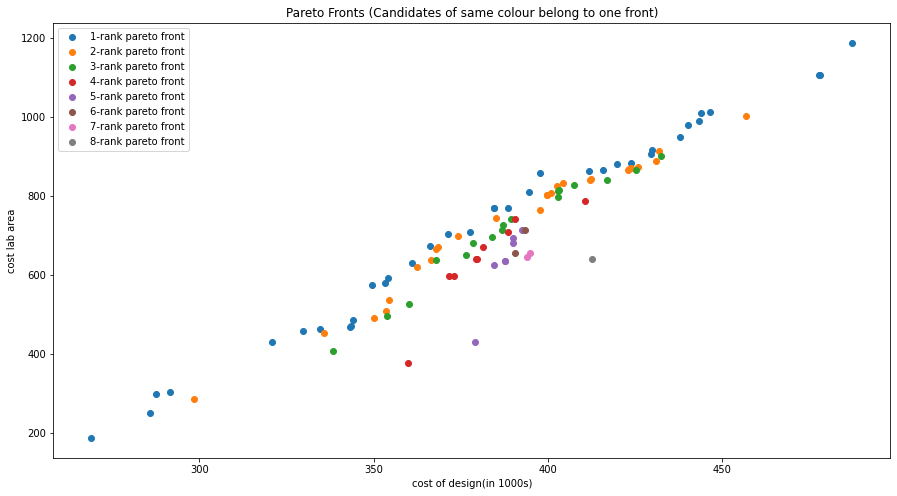

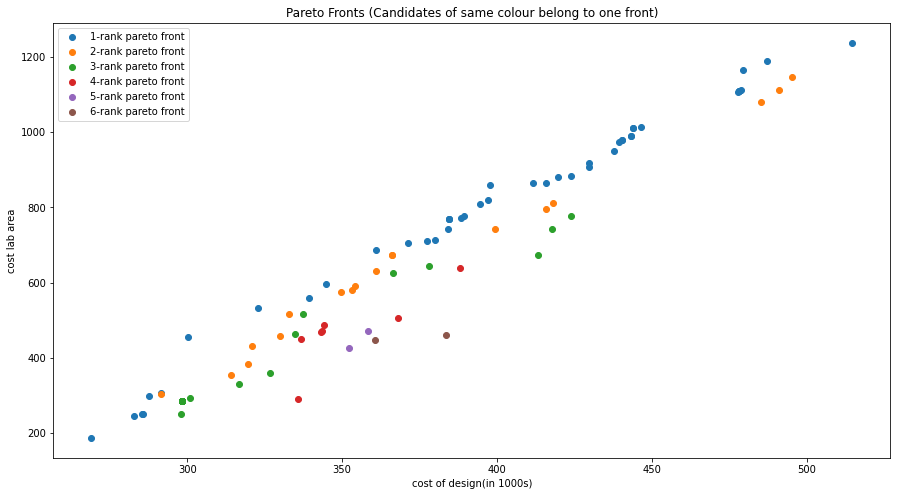

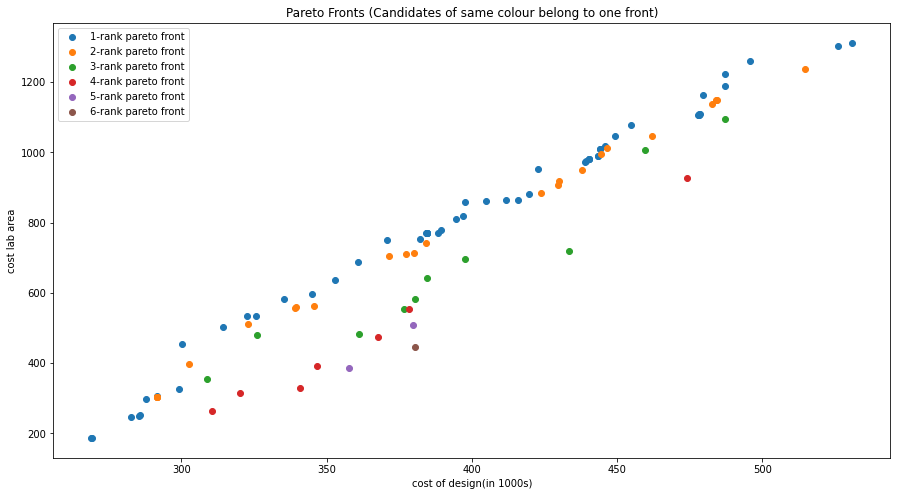

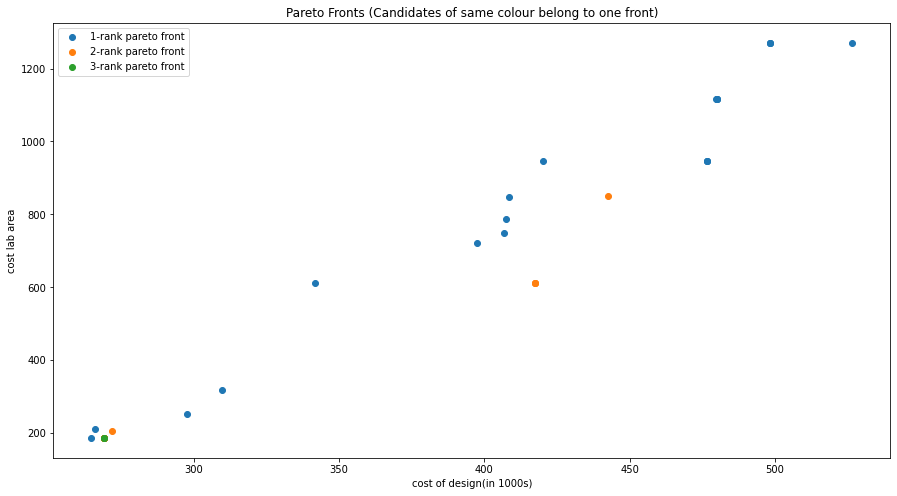

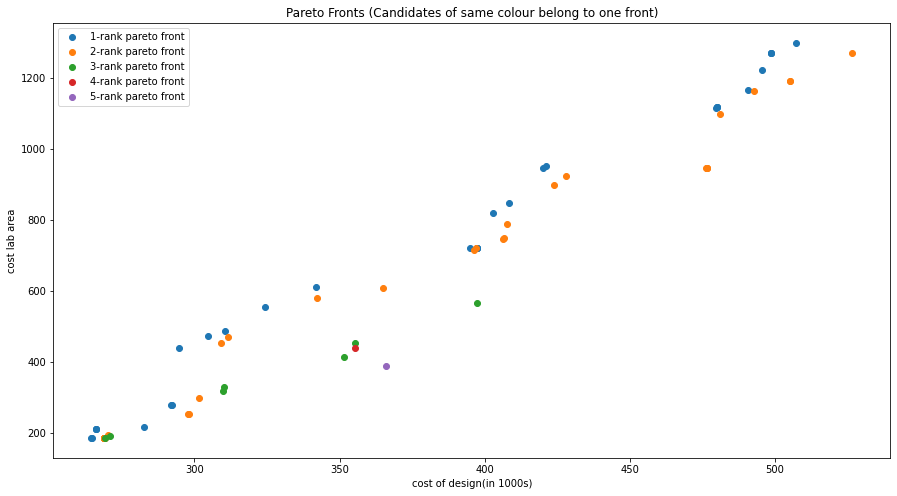

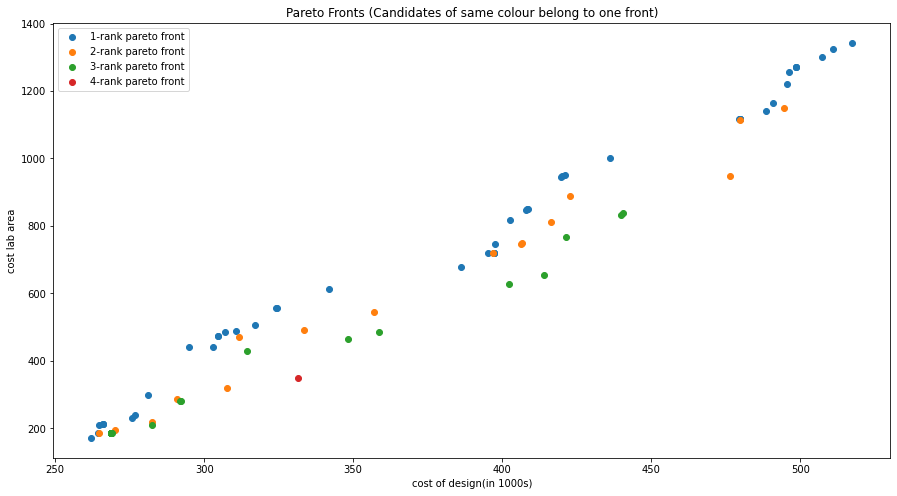

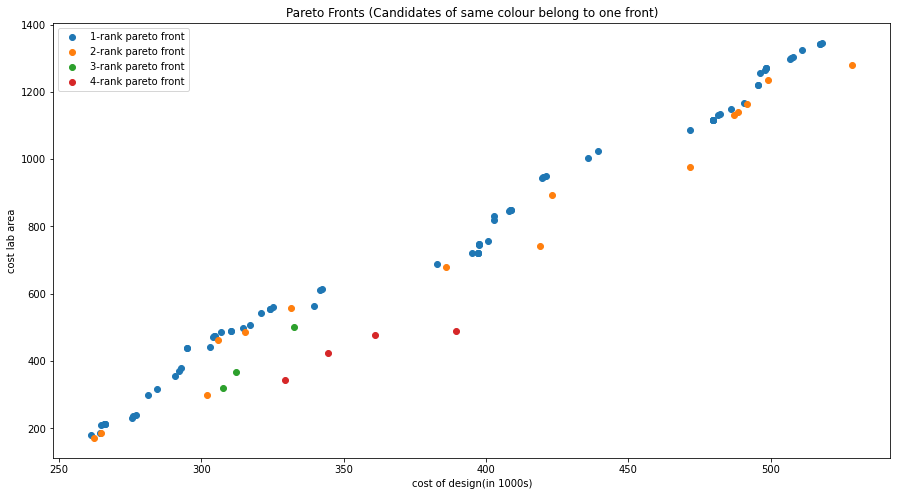

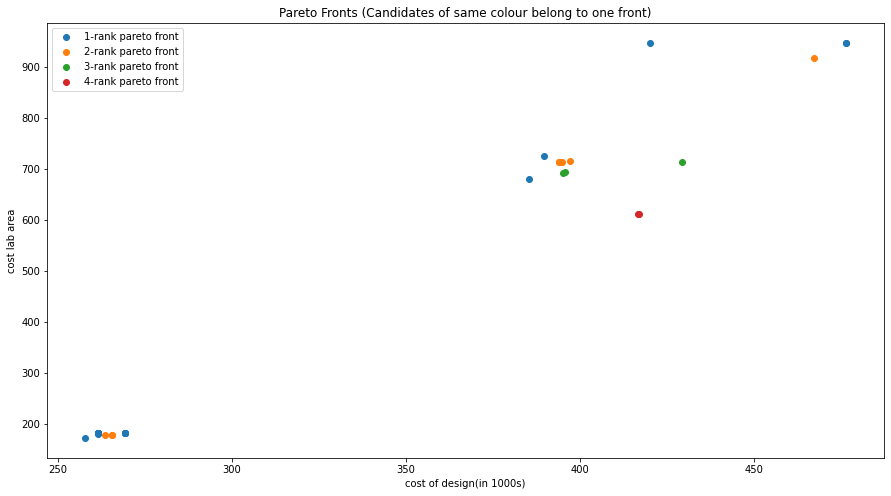

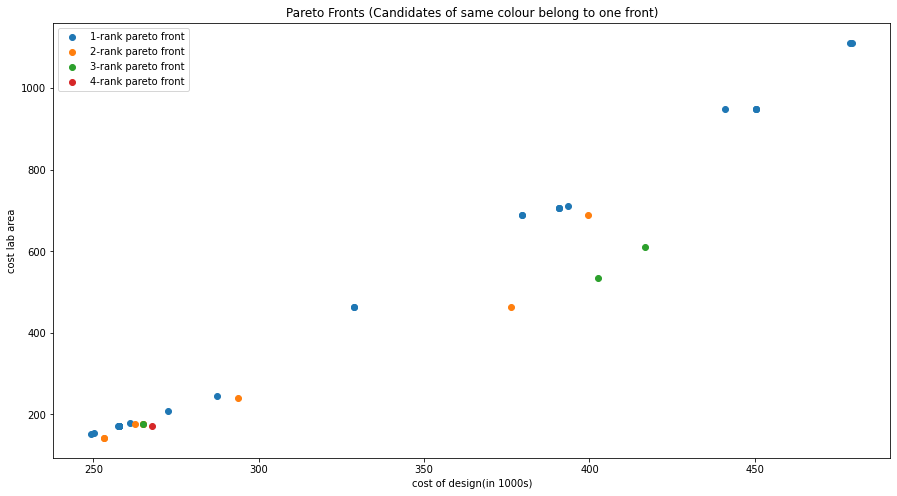

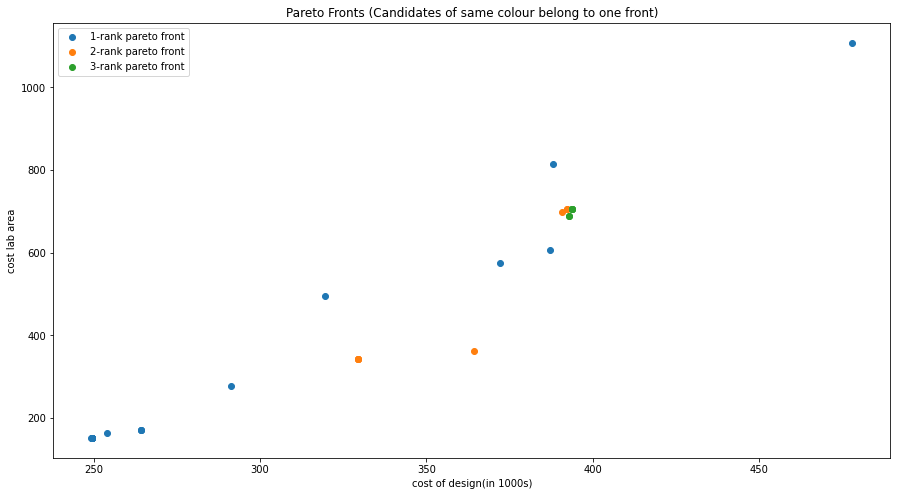

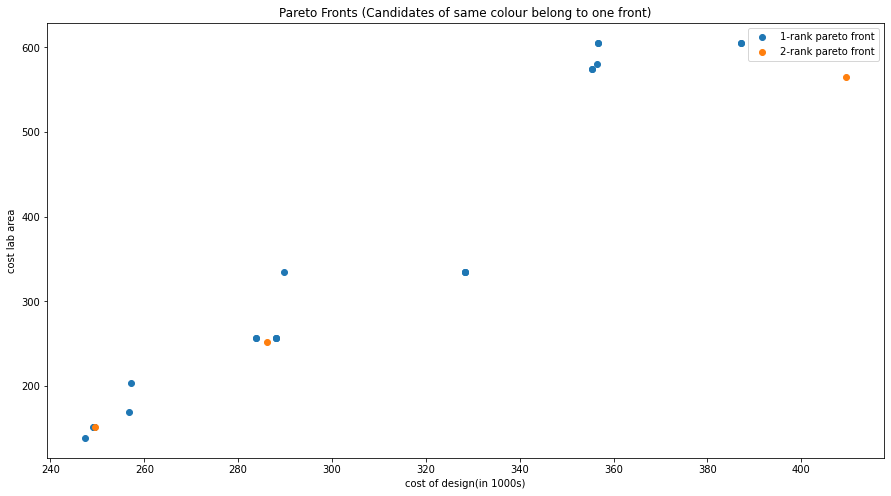

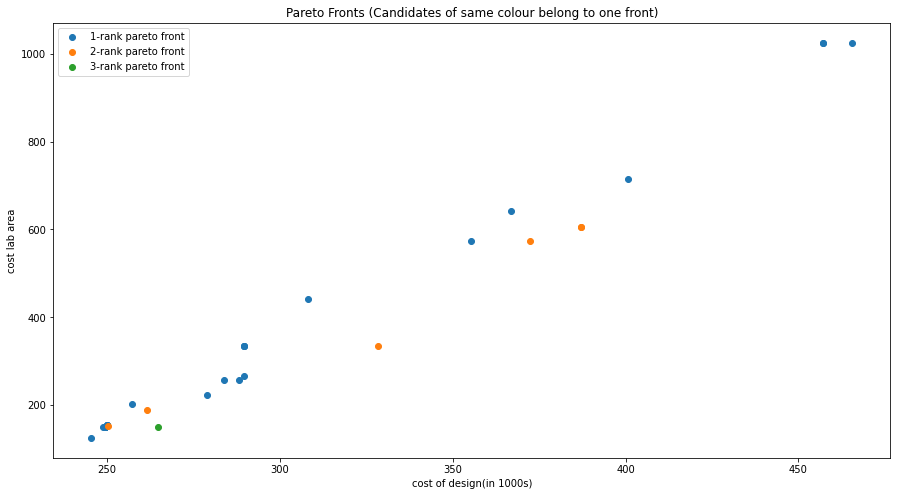

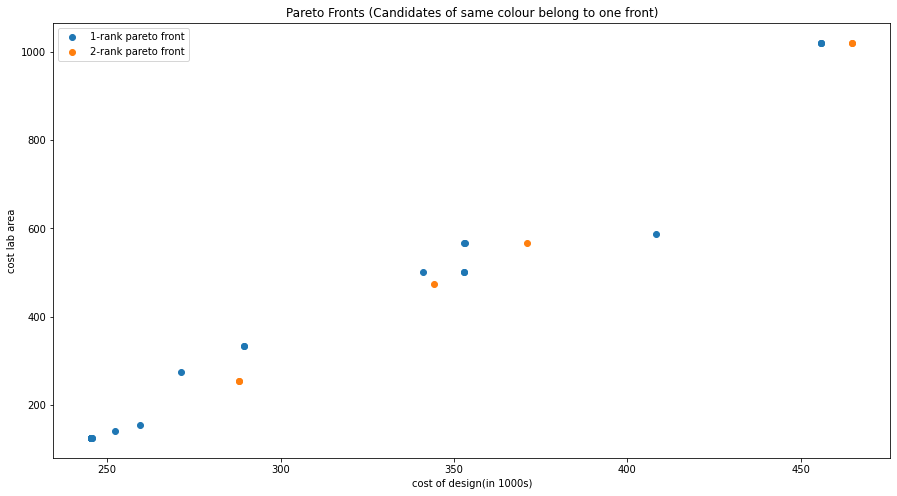

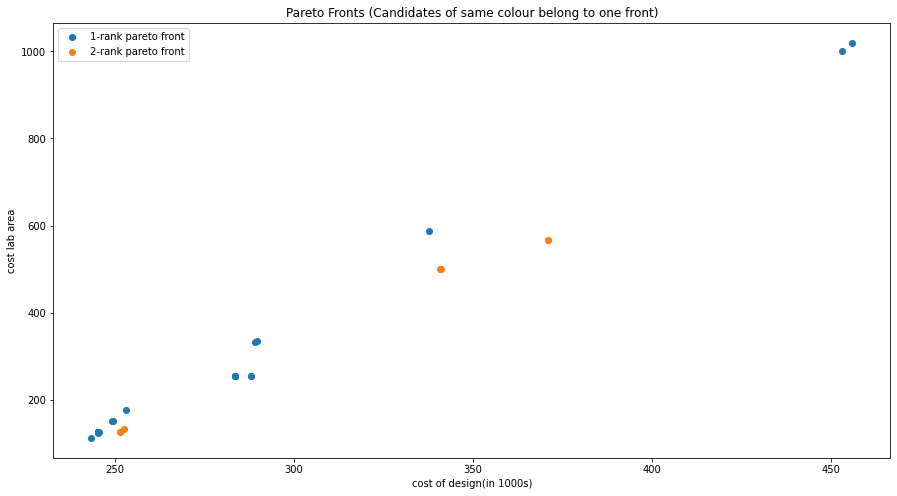

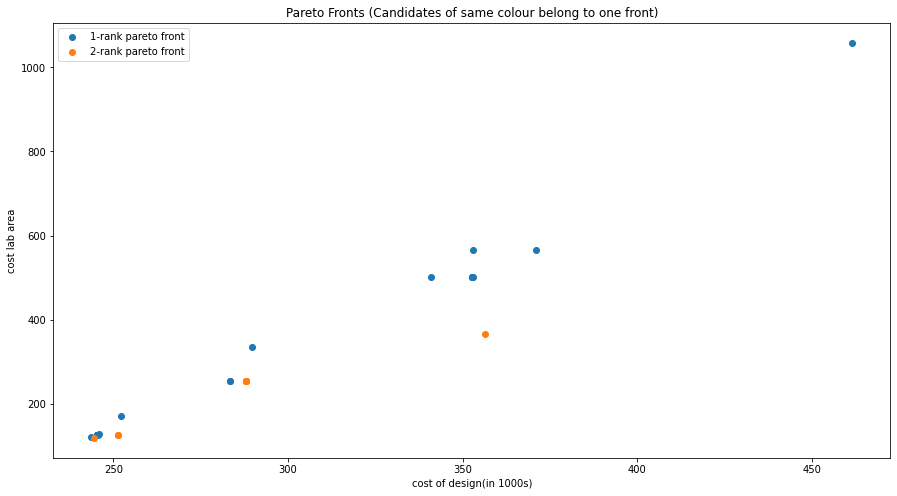

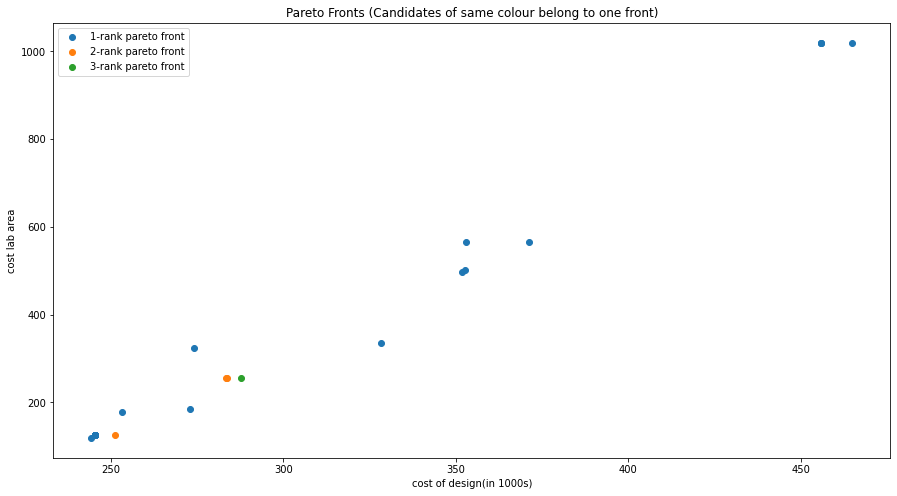

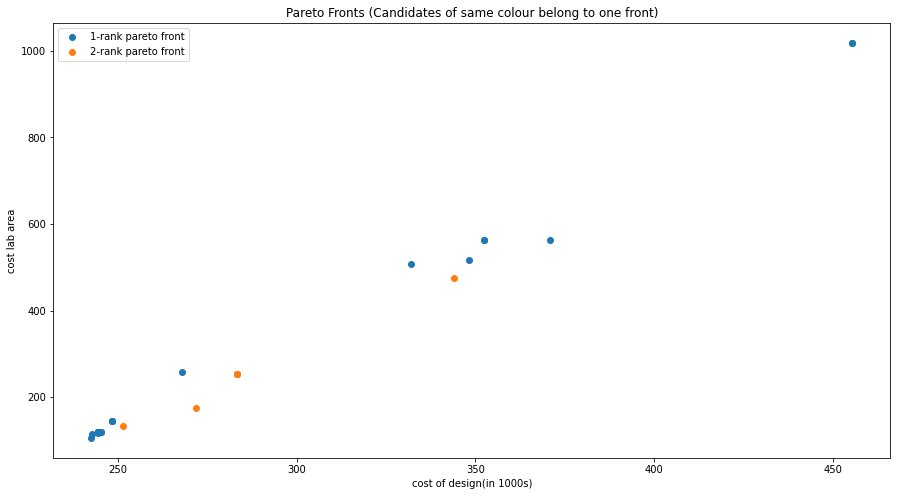

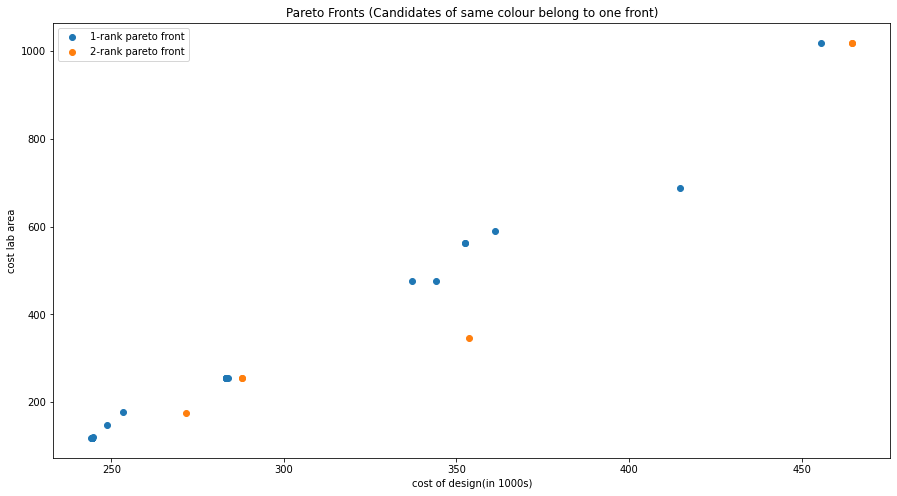

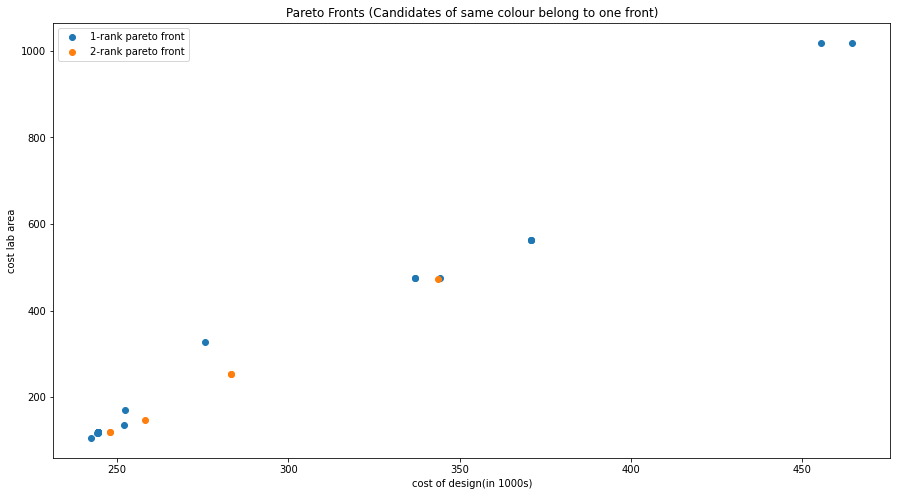

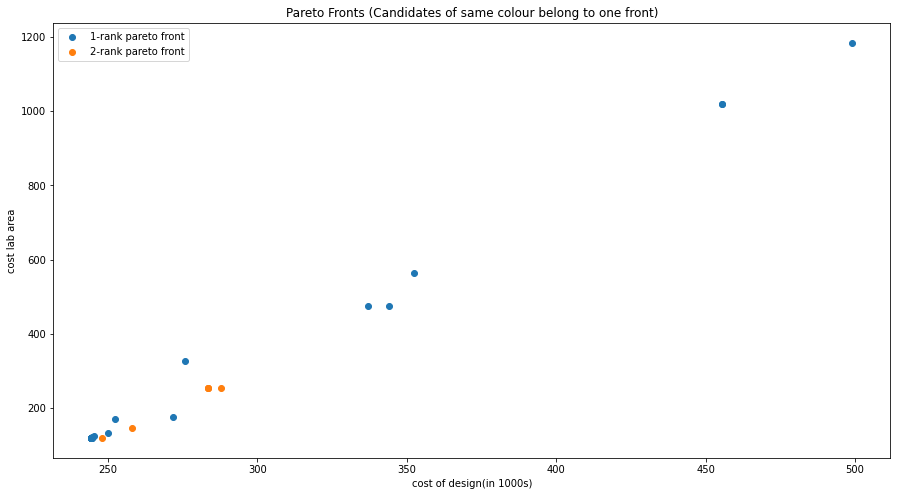

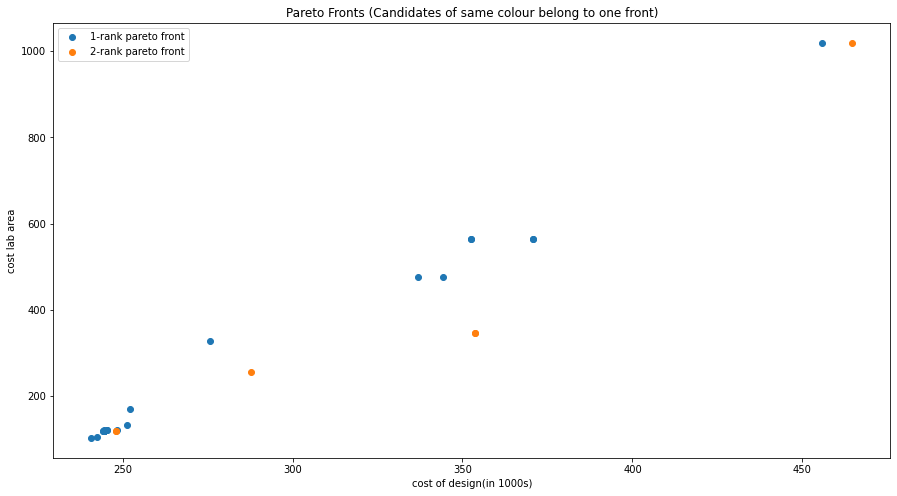

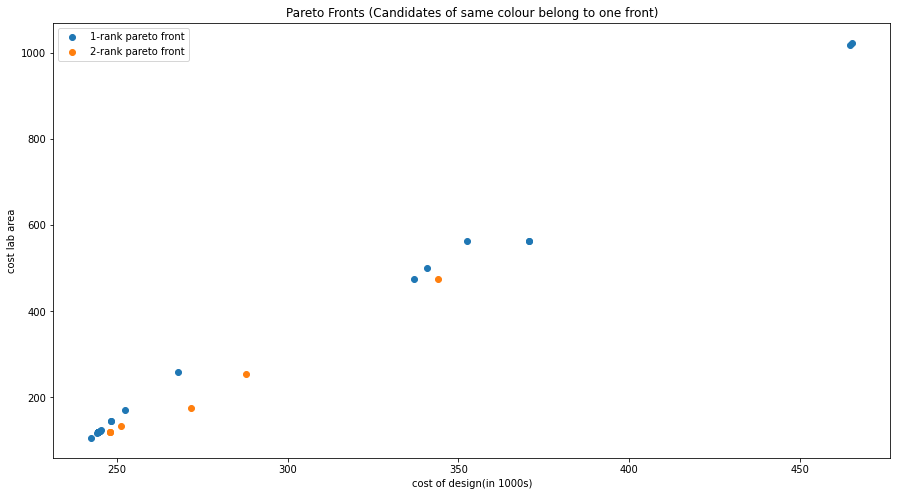

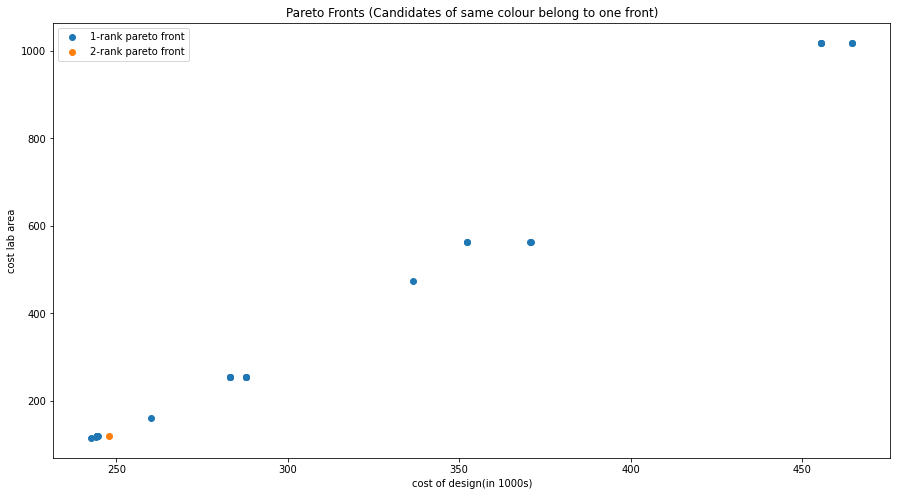

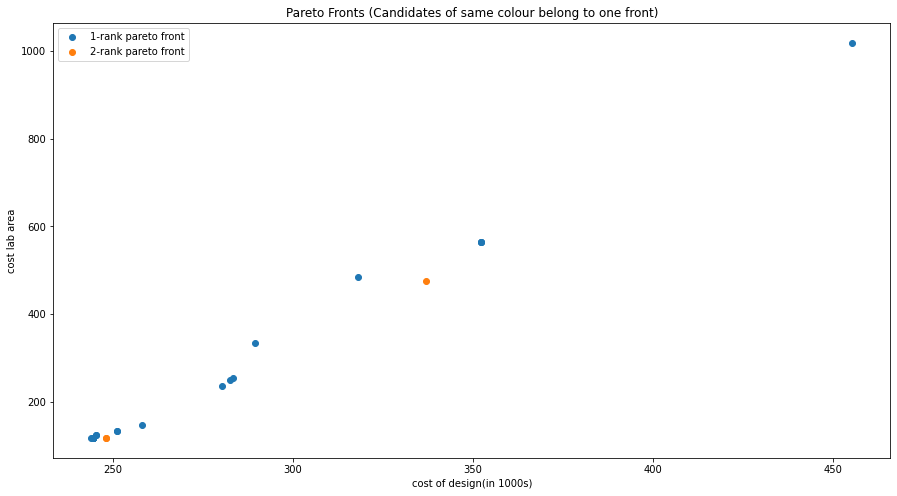

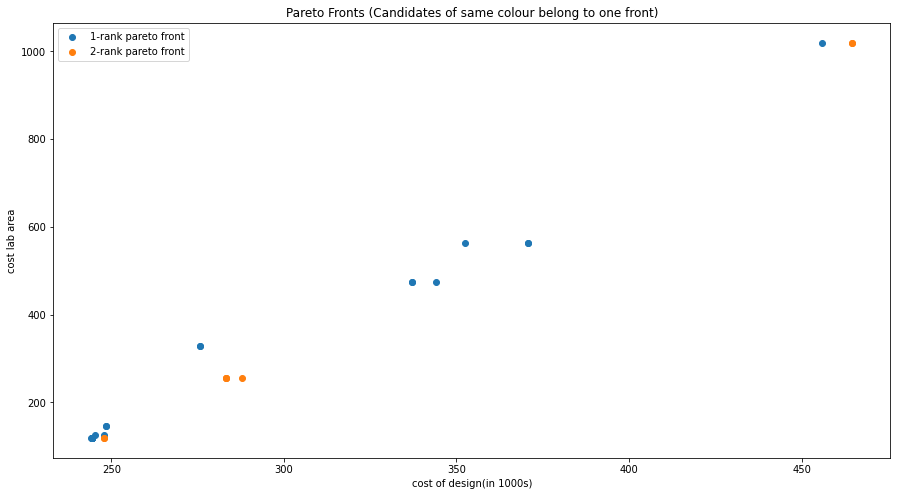

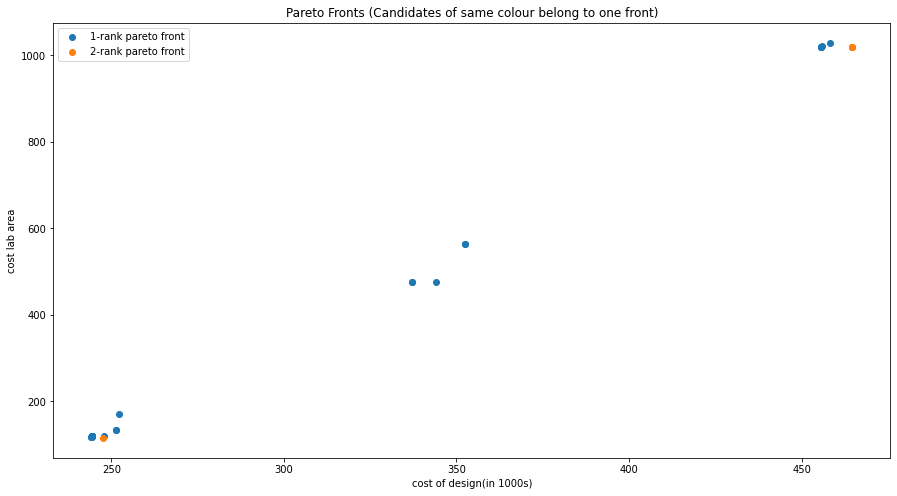

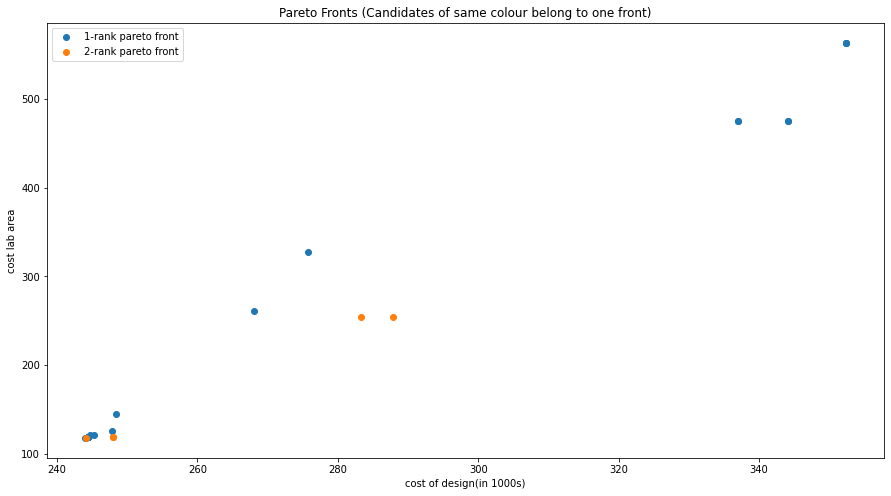

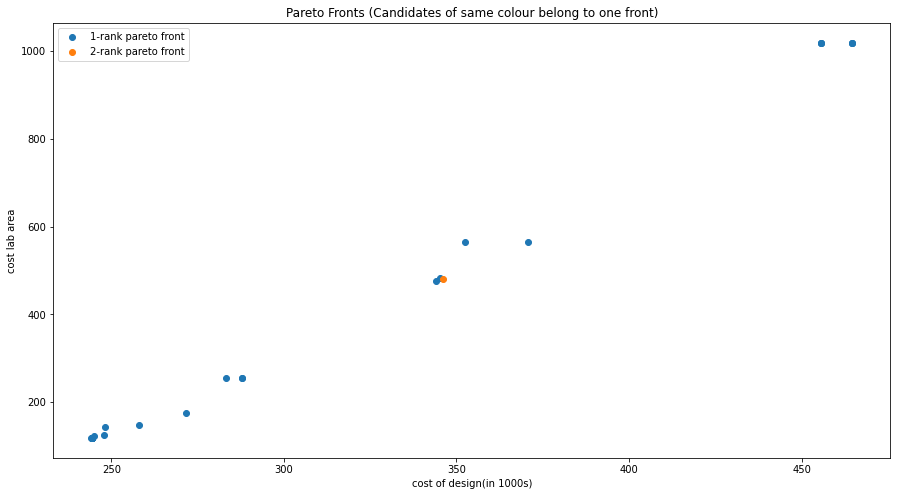

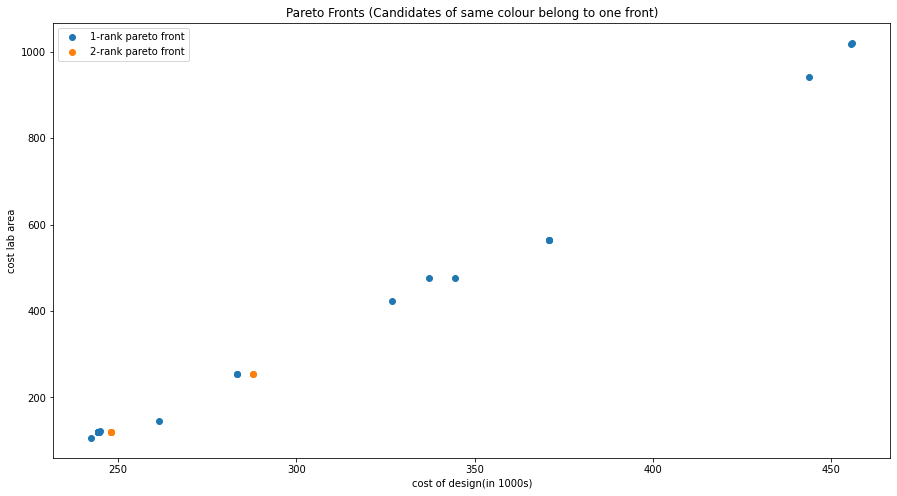

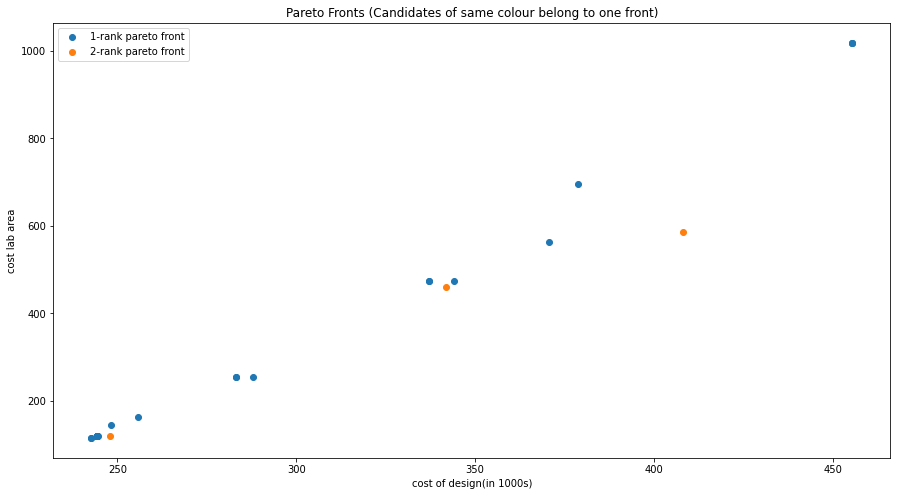

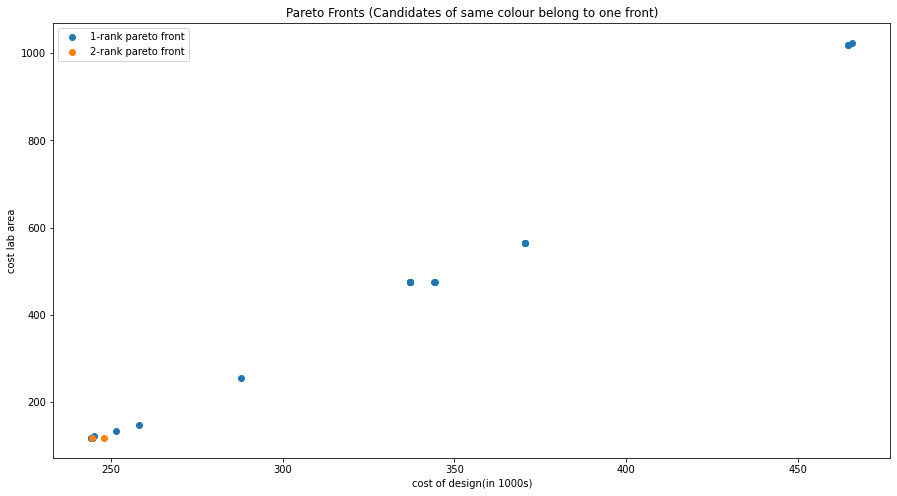

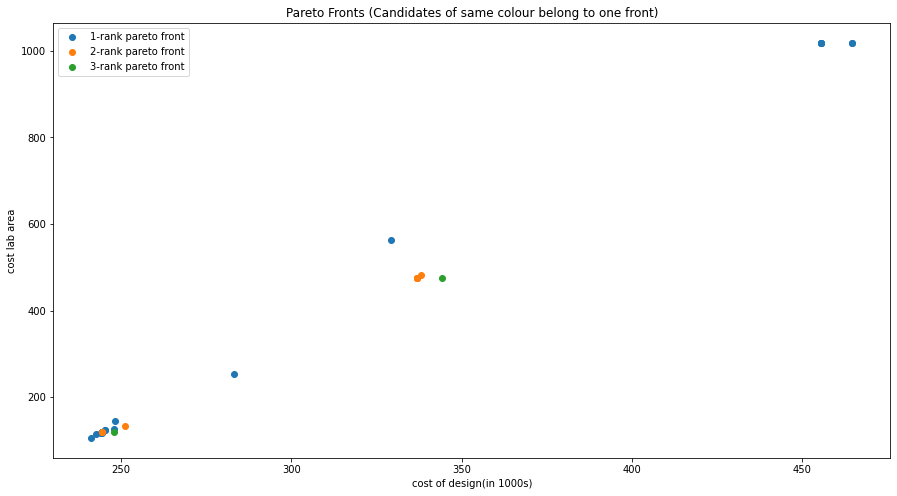

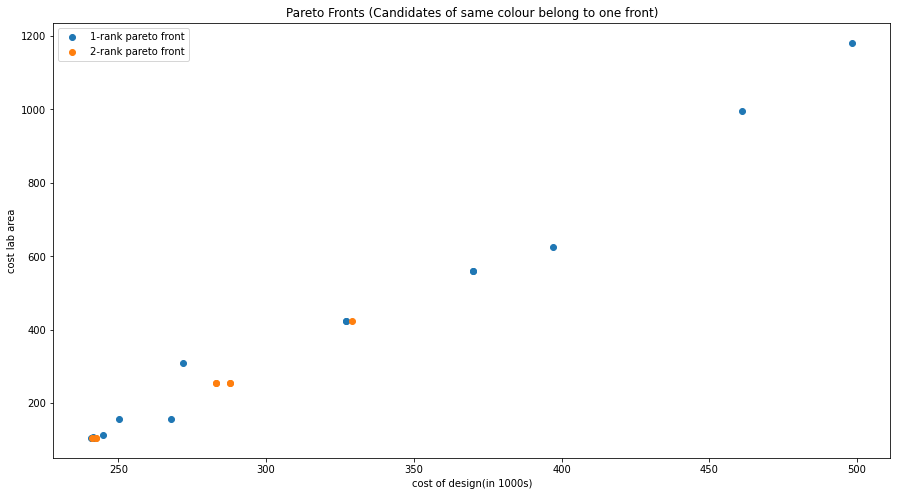

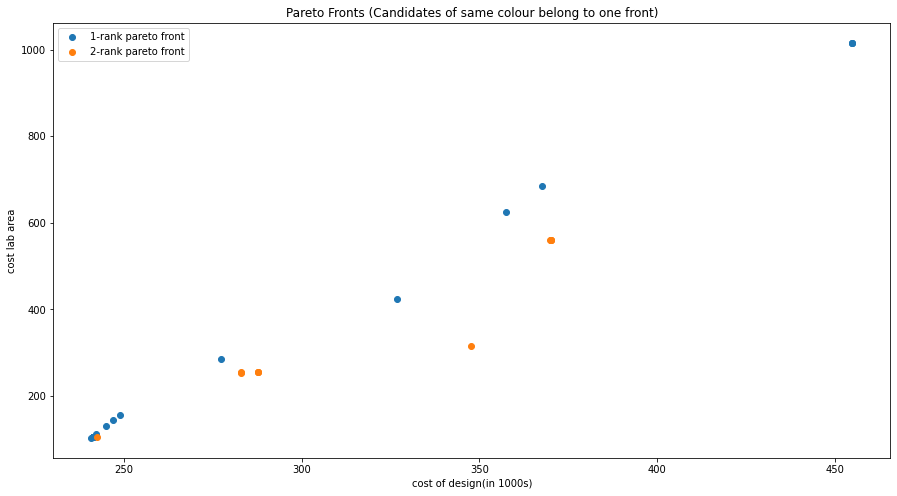

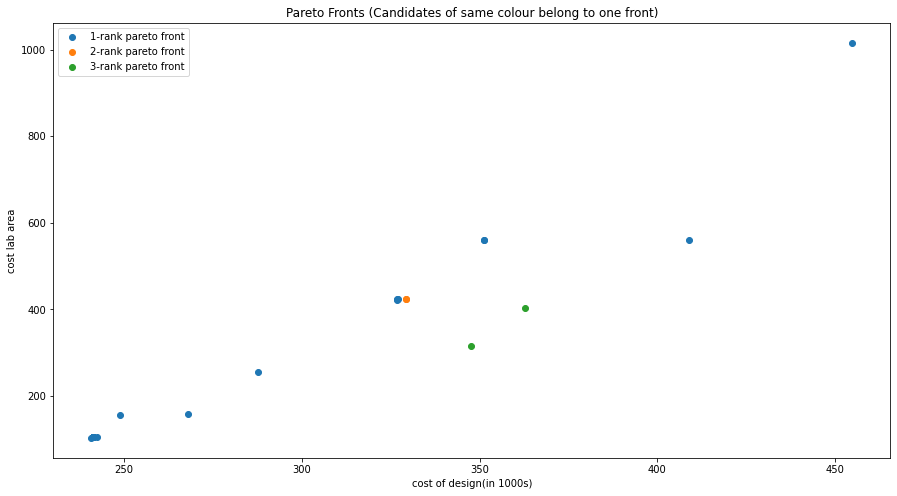

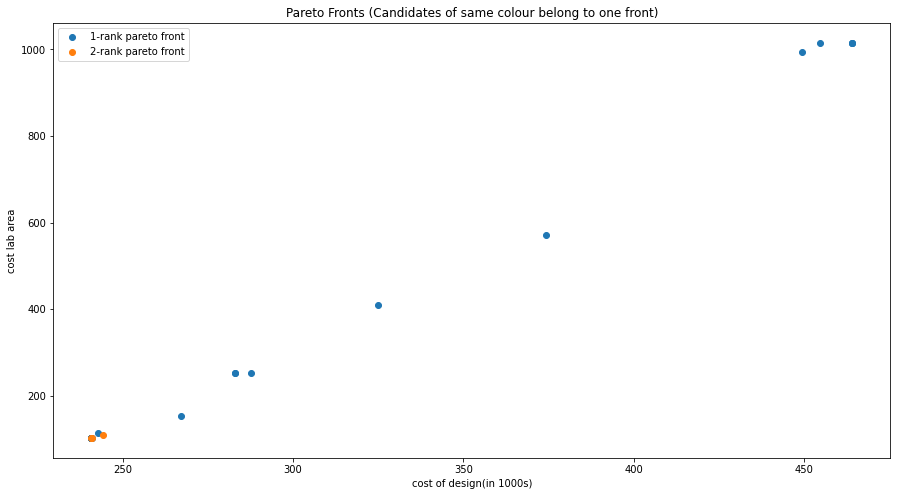

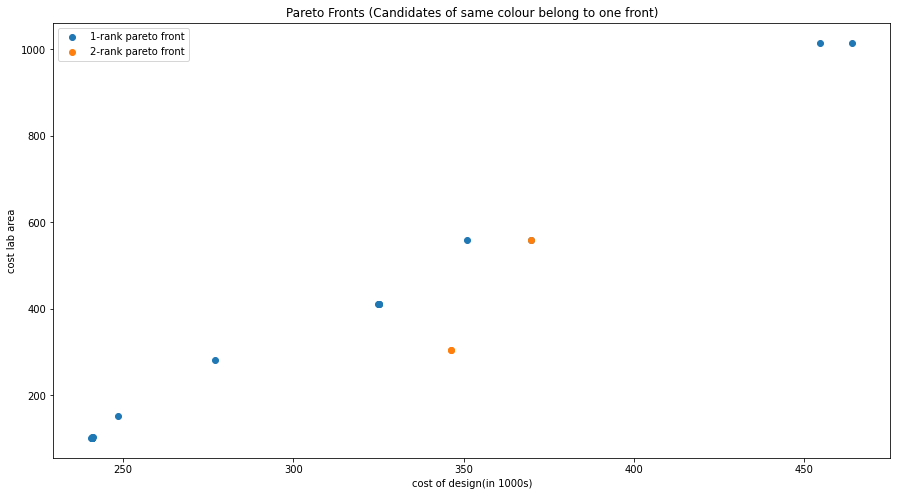

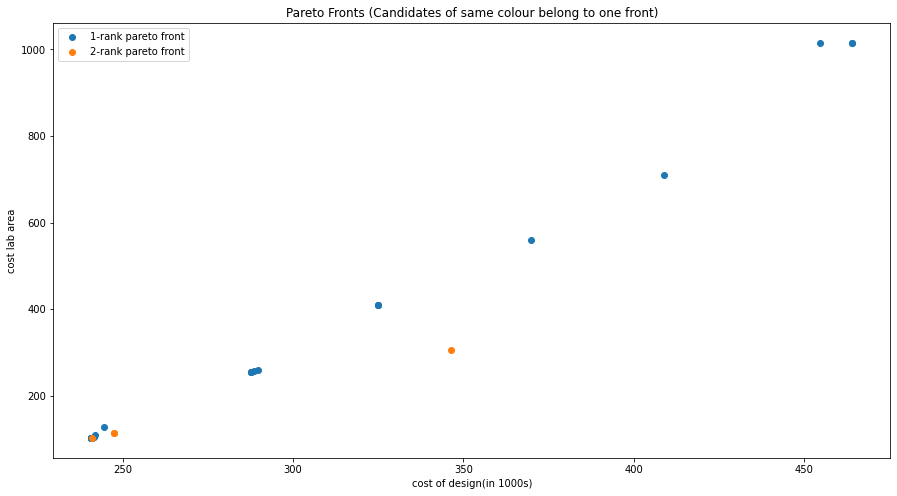

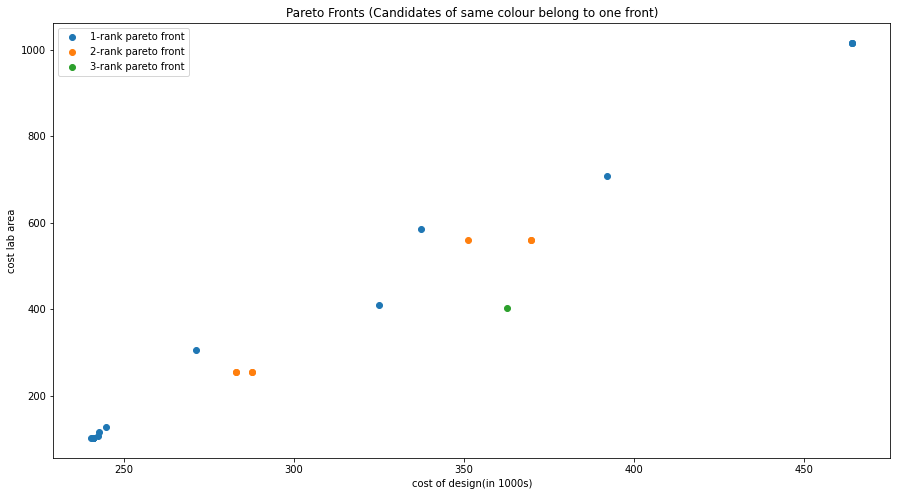

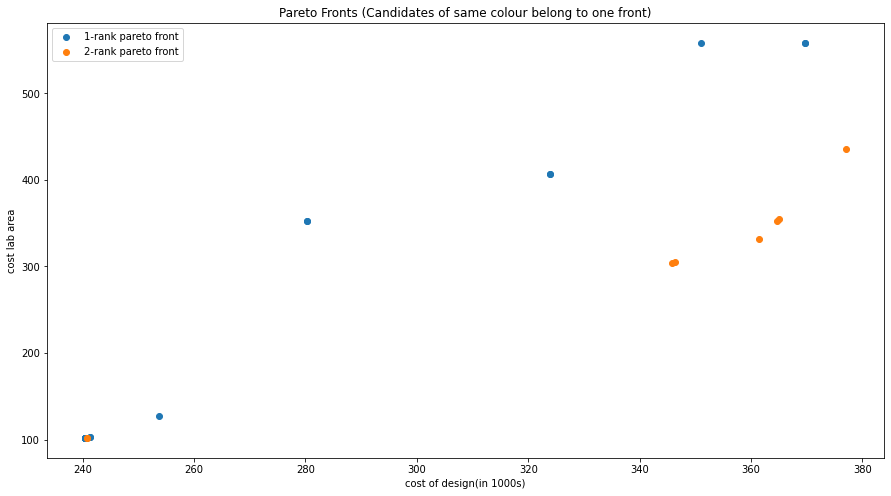

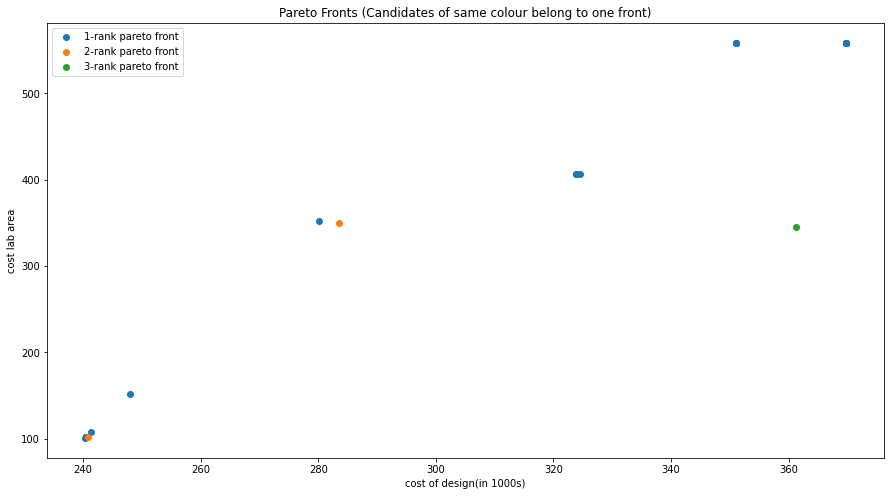

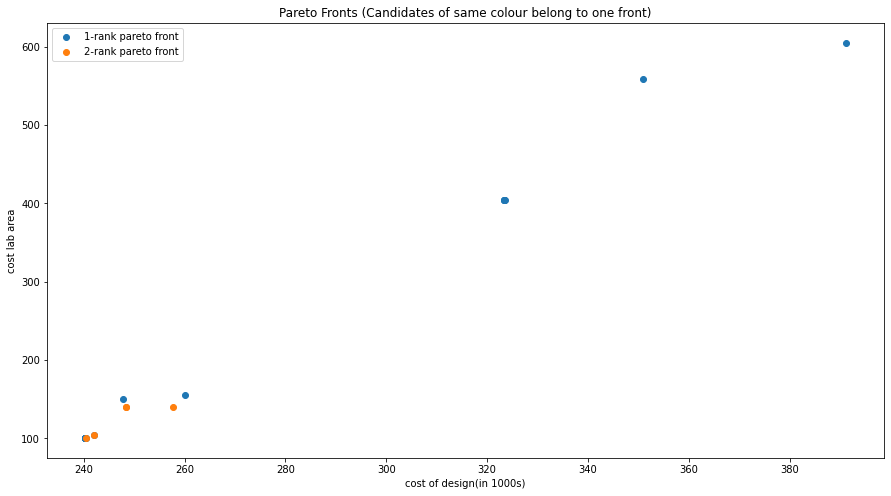

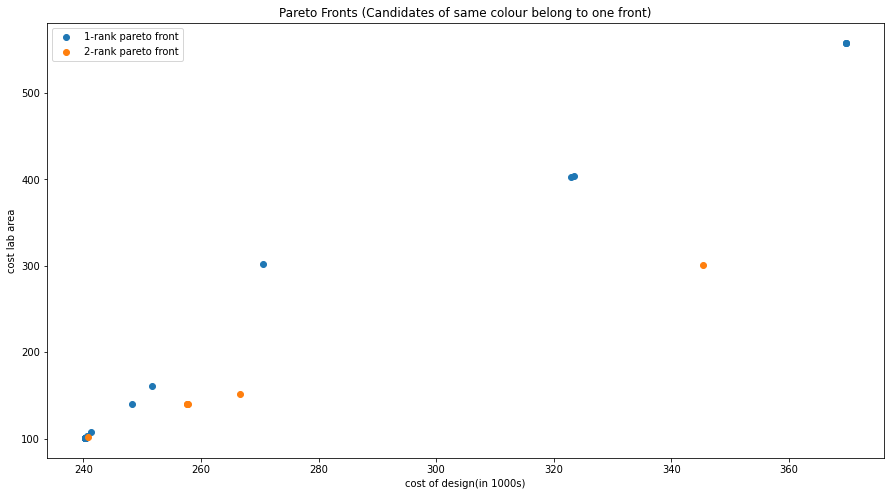

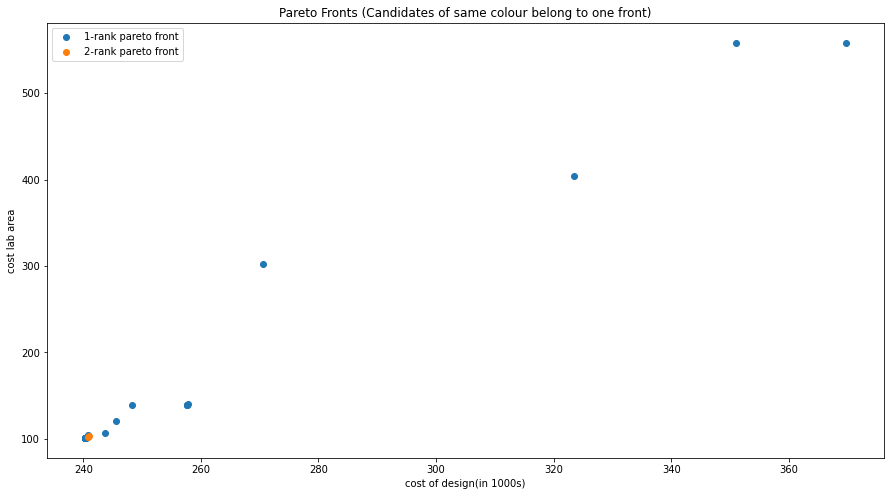

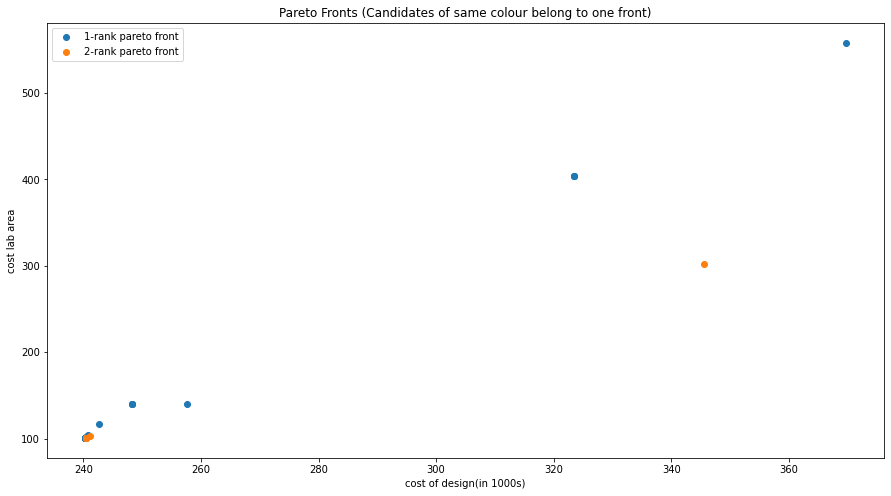

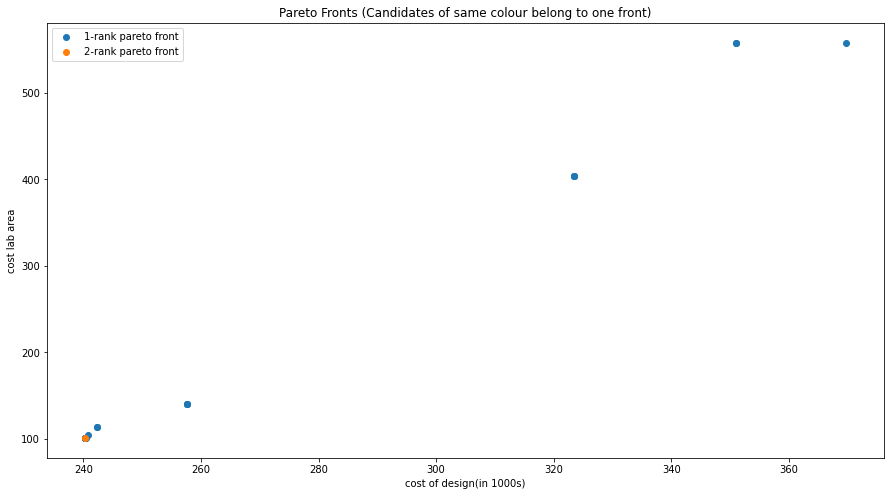

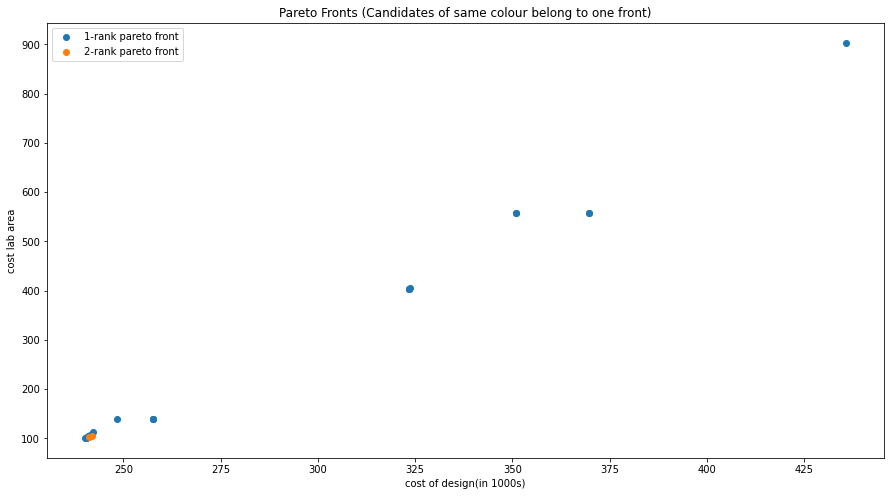

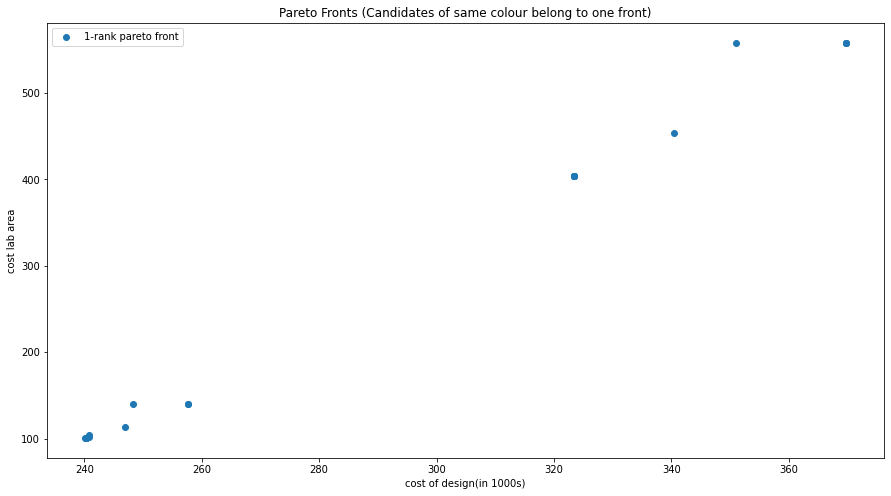

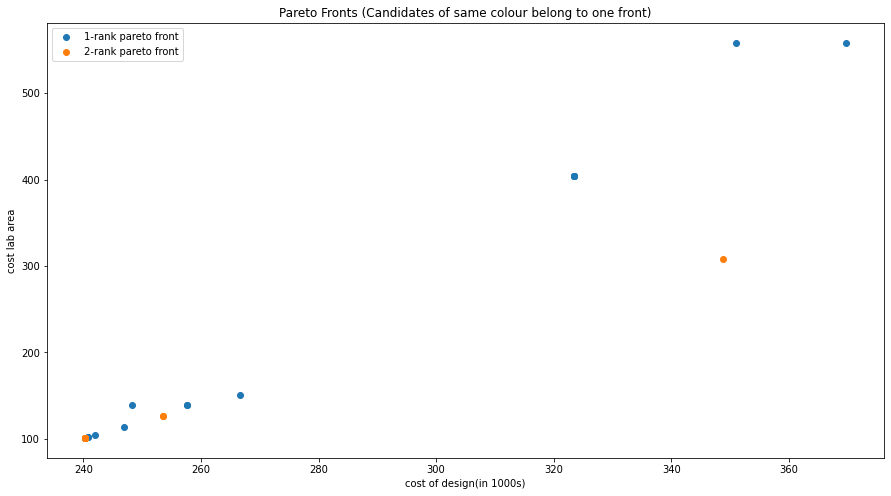

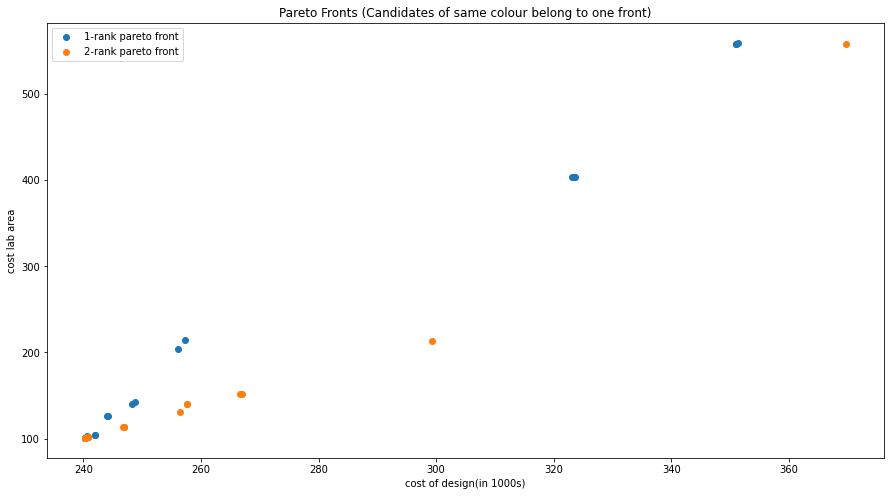

In [80]:
for i in range(len(fs)):
    pareto_front(fs[i],i)

In [81]:
print(fs[-1])

[[(240.2970657310888, 100.88126869089345), (323.49067015511633, 403.9176088829936), (240.31178576056706, 100.9794022207484), (241.9919131718728, 104.11967517610695), (240.2970657310888, 100.88126869089345), (350.98007462157614, 558.3576380080325), (323.4173921873587, 403.9176088829936), (240.31178576056706, 100.9794022207484), (240.31178576056706, 100.9794022207484), (240.3265057900453, 101.07753575060336), (323.49067015511633, 403.9176088829936), (323.49067015511633, 403.9176088829936), (248.30162588548686, 139.58940950200812), (240.31178576056706, 100.9794022207484), (240.36315909301896, 101.0776312112355), (240.2970657310888, 100.88126869089345), (350.98007462157614, 558.3576380080325), (240.31178576056706, 100.9794022207484), (257.32239430061844, 214.13919926189837), (240.31178576056706, 100.9794022207484), (323.1896720426117, 403.1322542622575), (351.35571817539403, 559.6406289041906), (240.28948735015368, 100.58648625879997), (244.12041797915094, 126.12602378544838), (241.9405541

In [82]:
top5_lls_iteration_wise[-1]

[10.043966780654616,
 20.08793356130923,
 10.053737176355641,
 10.043966780654616,
 10.043966780654616]

In [83]:
top5_lws_iteration_wise[-1]

[10.043966780654616,
 20.107474352711282,
 10.043966780654616,
 10.36638983878847,
 10.043966780654616]